# Information Retrieval

In [28]:
import ParserCACM
import TextRepresenter
import indexation
import modeles
from query import QueryParserCACM
import evaluation
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import operator
# Auto reload the imported modules when running cells
%load_ext autoreload 
%autoreload 2

""" Some info to remember when testing:
- Query 10 is about parallel computation
- Doc 46 is about parallelism too
"""

# Constants:
srcFolder = "cacm" 
srcFile = "cacm.txt"
qryFile = "cacm.qry"
relFile = "cacm.rel"
gendata = "gendata" #output folder
indexName = "cacm"
docId = 46
queryId = np.random.randint(1,60)
wordTest = "logic"

cacm_txt = os.path.join(srcFolder, srcFile)
cacm_qry = os.path.join(srcFolder, qryFile)
cacm_rel = os.path.join(srcFolder, relFile)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing the indexation:

In [29]:
# Construct the index:
idx = indexation.Index(indexName, gendata)
stemmer = TextRepresenter.PorterStemmer()
%time idx.indexation(cacm_txt, ParserCACM.ParserCACM(), stemmer)

Performing the indexation...
1st pass: build the index...
2nd pass: build the inverted index...
Finished.
CPU times: user 4.36 s, sys: 568 ms, total: 4.93 s
Wall time: 5.96 s


In [30]:
print("\n###### Testing the index: ###### ")
print("Retrieve common stems in doc %d:" % docId)
stems = sorted(idx.getTfsForDoc(docId).items(), key=operator.itemgetter(1), reverse=True)
print([stem for stem, freq in stems[:10]])
print("""Should look like
> “The tendency towards increased parallelism in
> computers is noted.  Exploitation of this parallelism
> presents a number of new problems in machine design
> and in programming systems...”""")

print("\nRetrieve docs that contains 'logic'")
docs = idx.getTfsForStem("logic") 
print(docs)
print("Should include doc 63 and 46:", (63 in docs.keys() and 46 in docs.keys()))


###### Testing the index: ###### 
Retrieve common stems in doc 46:
['program', 'programm', 'problem', 'parallel', 'logic', 'requir', 'stretch', 'discuss', 'met', 'minimum']
Should look like
> “The tendency towards increased parallelism in
> computers is noted.  Exploitation of this parallelism
> presents a number of new problems in machine design
> and in programming systems...”

Retrieve docs that contains 'logic'
{2817: 1, 3154: 6, 1030: 1, 2568: 1, 2313: 2, 3082: 1, 2060: 1, 2322: 1, 2067: 1, 22: 1, 2845: 1, 30: 1, 2848: 3, 2851: 1, 2054: 1, 3111: 1, 1834: 1, 1324: 1, 46: 2, 1327: 1, 2952: 1, 2871: 4, 3133: 5, 63: 2, 320: 8, 1602: 2, 2230: 1, 2888: 1, 3147: 1, 1101: 1, 2127: 2, 850: 1, 595: 2, 753: 1, 2145: 1, 2146: 2, 1381: 1, 2406: 3, 1383: 2, 1103: 1, 2931: 5, 1908: 1, 1398: 1, 3194: 1, 1916: 1, 2943: 1, 1155: 2, 1462: 1, 1928: 4, 1677: 1, 1718: 1, 1170: 1, 1173: 1, 2209: 1, 1700: 1, 2726: 3, 679: 2, 1195: 1, 1965: 1, 1456: 1, 2227: 1, 2484: 1, 1974: 6, 1208: 1, 1465: 1, 3008: 1

In [31]:
# Choosing what to test:
test_binaryweighter = True
test_tfidfweighter = True
test_queryparser = True
test_PRrecallmeasure = True
test_averageprecision = True
test_eval_ir_model = True
test_unigram_model = True
test_okapi = True

## Testing the weighters:

In [7]:
query = stemmer.getTextRepresentation(" Parallel languages; languages for parallel computation")

if test_binaryweighter:
    print("\n#####Testing BinaryWeighter: #####")

    bw = modeles.BinaryWeighter(idx)
    print("bw.getDocWeightsForDoc(",docId,"):", 
        bw.getDocWeightsForDoc(docId))
    print("\nbw.getDocWeightsForStem('"+wordTest+"'):", 
        bw.getDocWeightsForStem(wordTest))
    print("\nbw.getWeightsForQuery(' Parallel languages; languages for parallel computation'):", 
        bw.getWeightsForQuery(query))

    print("\n#####Testing Vectoriel with BinaryWeighter: #####")
    vect = modeles.Vectoriel(idx, bw)
    print("Top 10 documents for the previous query:")
    print("""Should include some of the following docs: 1043, 1188, 1306, 
    1358, 1396, 1491, 1923, 2246, 2316, 2527, 2699, 2710, 2715, 2716, 
    2906, 2923, 2956, 3073, 3150, """)
    print(vect.getRanking(query)[:10])
else:
    print("\n##### Skipping the test of BinaryWeighter #####")
    


#####Testing BinaryWeighter: #####
bw.getDocWeightsForDoc( 46 ): {'discuss': 1, 'met': 1, 'minimum': 1, 'feasibl': 1, 'present': 1, 'burden': 1, 'tendenc': 1, 'parallel': 2, 'design': 1, 'number': 1, 'logic': 2, 'codd': 1, 'system': 1, 'describ': 1, 'programm': 3, 'execut': 1, 'combin': 1, 'scalzi': 1, 'techniqu': 1, 'note': 1, 'concurr': 1, 'balanc': 1, 'carefulli': 1, 'requir': 2, 'stretch': 2, 'compil': 1, 'consider': 1, 'built': 1, 'success': 1, 'comput': 1, 'lowri': 1, 'machin': 1, 'increas': 1, 'problem': 3, 'exploit': 1, 'independ': 1, 'program': 4, 'mcdonough': 1, 'place': 1, 'supervisori': 1, 'multiprogramm': 1}

bw.getDocWeightsForStem('logic'): {2817: 1, 3154: 6, 1030: 1, 2568: 1, 2313: 2, 3082: 1, 2060: 1, 2322: 1, 2067: 1, 22: 1, 2845: 1, 30: 1, 2848: 3, 2851: 1, 2054: 1, 3111: 1, 1834: 1, 1324: 1, 46: 2, 1327: 1, 2952: 1, 2871: 4, 3133: 5, 63: 2, 320: 8, 1602: 2, 2230: 1, 2888: 1, 3147: 1, 1101: 1, 2127: 2, 850: 1, 595: 2, 753: 1, 2145: 1, 2146: 2, 1381: 1, 2406: 3, 1383

In [8]:
tfidfWeighter = modeles.TfidfWeighter(idx)
vect = modeles.Vectoriel(idx, tfidfWeighter)

if test_tfidfweighter:
    print("\n###### Testing TfidfWeighter: ###### ")
    print("tfidfWeighter.getDocWeightsForDoc(", docId, "):",
         tfidfWeighter.getDocWeightsForDoc(docId))
    print("\ntfidfWeighter.getDocWeightsForStem(\"logic\"):",
         tfidfWeighter.getDocWeightsForStem(wordTest))
    print("\ntfidfWeighter.getWeightsForQuery(query):",
         tfidfWeighter.getWeightsForQuery(query))
    print("\n###### Testing Vectoriel with TfidfWeighter: ###### ")
    print("Top 10 documents for the query:")
    print(vect.getRanking(query)[:10])
else:
    print("\n##### Skipping the test of TfidfWeighter #####")


###### Testing TfidfWeighter: ###### 
tfidfWeighter.getDocWeightsForDoc( 46 ): {'discuss': 1, 'met': 1, 'minimum': 1, 'feasibl': 1, 'present': 1, 'burden': 1, 'tendenc': 1, 'parallel': 2, 'design': 1, 'number': 1, 'logic': 2, 'codd': 1, 'system': 1, 'describ': 1, 'programm': 3, 'execut': 1, 'combin': 1, 'scalzi': 1, 'techniqu': 1, 'note': 1, 'concurr': 1, 'balanc': 1, 'carefulli': 1, 'requir': 2, 'stretch': 2, 'compil': 1, 'consider': 1, 'built': 1, 'success': 1, 'comput': 1, 'lowri': 1, 'machin': 1, 'increas': 1, 'problem': 3, 'exploit': 1, 'independ': 1, 'program': 4, 'mcdonough': 1, 'place': 1, 'supervisori': 1, 'multiprogramm': 1}

tfidfWeighter.getDocWeightsForStem("logic"): {2817: 1, 3154: 6, 1030: 1, 2568: 1, 2313: 2, 3082: 1, 2060: 1, 2322: 1, 2067: 1, 22: 1, 2845: 1, 30: 1, 2848: 3, 2851: 1, 2054: 1, 3111: 1, 1834: 1, 1324: 1, 46: 2, 1327: 1, 2952: 1, 2871: 4, 3133: 5, 63: 2, 320: 8, 1602: 2, 2230: 1, 2888: 1, 3147: 1, 1101: 1, 2127: 2, 850: 1, 595: 2, 753: 1, 2145: 1, 2146: 

## Testing the QueryParser

In [9]:
if test_queryparser:
    print("\n###### Testing QueryParserCACM: ###### ")
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for query #%d:" % queryId)
    while query is not None and query.getID() != str(queryId):
        #print(query)
        #print(20*'-')
        query = qp.nextQuery()

    print("Query:", query)
    queryTxt = stemmer.getTextRepresentation(query.getText())
    print("\nCompute scores:")
    scores = vect.getRanking(queryTxt)
    print(scores[:10])
    print("Done.")
else:
    print("\n##### Skipping the test of QueryParserCACM #####")


###### Testing QueryParserCACM: ###### 
Searching for query #22:
Query: Query {id=22, txt='I am interested in hidden-line and hidden-surface algorithms for
cylinders, toroids, spheres, and cones.  This is a rather specialized
topic in computer graphics.
', relevances=[2369, 2384, 2441, 2473, 2564, 2637, 2638, 2678, 2692, 2751, 2760, 2761, 2827, 2828, 2829, 3116, 3149]}

Compute scores:
[('2678', 0.2994111204321816), ('2473', 0.27274912289286957), ('2384', 0.27274912289286957), ('2827', 0.21367291323250295), ('2751', 0.21316287735822653), ('2638', 0.18799813643457414), ('2637', 0.18799813643457414), ('2564', 0.18799813643457414), ('2441', 0.18799813643457414), ('2924', 0.17567493572448997)]
Done.


## Testing precision/recall measure:



###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 10, 25]
Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[1198, 1338, 1877, 1960, 2150, 2228, 2256, 2280, 2320, 2342, 2376, 2482, 2578, 2597, 2618, 2685, 2700, 2777, 2865, 2866, 2895, 2912, 2941, 3043, 3082, 3128, 3141, 3148]}
Retrieve scores...
CPU times: user 256 ms, sys: 36 ms, total: 292 ms
Wall time: 348 ms
Create PrecisionRecallMeasure object
Evaluate the scores.
This query has 28 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.035714
    2|   2 | 1.000000  |0.071429
    4|   3 | 0.750000  |0.107143
   12|   4 | 0.333333  |0.142857
   13|   5 | 0.384615  |0.178571
   19|   6 | 0.315789  |0.214286
   21|   7 | 0.333333  |0.25

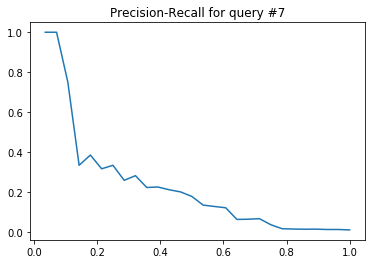

--------------------
Query: Query {id=10, txt='Parallel languages; languages for parallel computation
', relevances=[46, 141, 392, 950, 1158, 1198, 1262, 1380, 1471, 1601, 1613, 1747, 1795, 1811, 2060, 2150, 2256, 2289, 2342, 2376, 2433, 2618, 2664, 2685, 2700, 2714, 2777, 2785, 2851, 2895, 2896, 2912, 3039, 3075, 3156]}
Retrieve scores...
CPU times: user 284 ms, sys: 152 ms, total: 436 ms
Wall time: 389 ms
Create PrecisionRecallMeasure object
Evaluate the scores.
This query has 35 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.028571
    2|   2 | 1.000000  |0.057143
    3|   3 | 1.000000  |0.085714
    4|   4 | 1.000000  |0.114286
    5|   5 | 1.000000  |0.142857
    8|   6 | 0.750000  |0.171429
    9|   7 | 0.777778  |0.200000
   10|   8 | 0.800000  |0.228571
   11|   9 | 0.818182  |0.257143
   12|  10 | 0.833333  |0.285714
   13|  11 | 0.846154  |0.314286
   18|  12 | 0.666667  |0.342857
   19|  13 | 0.684211  |0.371429
   26|  14 | 0.538462  |0.400000
  

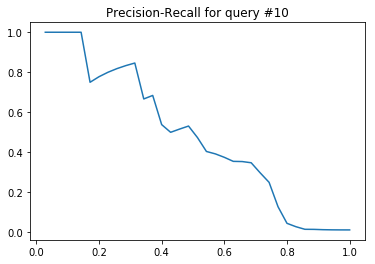

--------------------
Query: Query {id=25, txt='Performance evaluation and modelling of computer systems
', relevances=[268, 757, 963, 1408, 1518, 1526, 1533, 1572, 1653, 1698, 1719, 1805, 1892, 1901, 2085, 2095, 2218, 2277, 2318, 2319, 2358, 2373, 2434, 2452, 2535, 2582, 2667, 2668, 2669, 2681, 2741, 2765, 2798, 2818, 2831, 2859, 2862, 2863, 2881, 2918, 2928, 2984, 2988, 2996, 3006, 3048, 3059, 3067, 3088, 3089, 3119]}
Retrieve scores...
CPU times: user 256 ms, sys: 144 ms, total: 400 ms
Wall time: 347 ms
Create PrecisionRecallMeasure object
Evaluate the scores.
This query has 51 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.019608
    2|   2 | 1.000000  |0.039216
    4|   3 | 0.750000  |0.058824
    5|   4 | 0.800000  |0.078431
    6|   5 | 0.833333  |0.098039
    7|   6 | 0.857143  |0.117647
   11|   7 | 0.636364  |0.137255
   14|   8 | 0.571429  |0.156863
   16|   9 | 0.562500  |0.176471
   17|  10 | 0.588235  |0.196078
   18|  11 | 0.611111  |0.215686
 

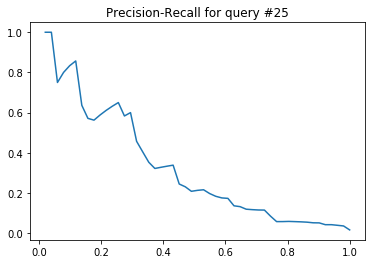

--------------------
Done.


In [15]:
if test_PRrecallmeasure:
    print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
    queryChosen = np.random.randint(1, 50, size=10)
    queryChosen =[7, 10, 25]#, 14, 26, 27, 42, 43] # lots of relevant results
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for query #", queryChosen)
    while query is not None :
        if int(query.getID()) in queryChosen:
            print("Query:", query)
            queryTxt = stemmer.getTextRepresentation(query.getText())
            print("Retrieve scores...")
            %time ranking = vect.getRanking(queryTxt)
            print("Create PrecisionRecallMeasure object")
            irlist = evaluation.IRList(query, ranking)
            precisRecall = evaluation.PrecisionRecallMeasure(irlist)
            print("Evaluate the scores.")
            pr = precisRecall.eval(verbose=True, nbLevel=100) # (recall, precision)
            precision = [p for r,p in pr]
            recall = [r for r,p in pr]
            plt.plot(recall, precision)
            plt.title("Precision-Recall for query #"+query.getID())
            plt.show()
            print(20*'-')


        query = qp.nextQuery()
    print("Done.")
else:
    print("\n##### Skipping the test of PrecisionRecallMeasure #####")

## Testing average precision:

In [16]:
if test_averageprecision:
    print("\n###### Testing evaluation.AveragePrecision: ###### ")
    queryChosen = np.random.randint(1, 50, size=10)
    #queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for query #",queryChosen, "\n")
    while query is not None :
        if int(query.getID()) in queryChosen:
            print("Query:", query)
            queryTxt = stemmer.getTextRepresentation(query.getText())
            print("Retrieve scores...")
            scores = vect.getRanking(queryTxt)
            irlist = evaluation.IRList(query, scores)
            average_measure = evaluation.AveragePrecision(irlist)
            print("Evaluate the scores.")
            average_prec = average_measure.eval(verbose=True)
            print("Average precision: %f" % average_prec)
            print(20*'-')

        query = qp.nextQuery()
    print("Done.")
else:
    print("\n##### Skipping the test of AveragePrecision #####")


###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [ 5  2  8 21 10 39 16  6 13 20] 

Query: Query {id=2, txt='I am interested in articles written either by Prieve or Udo Pooch
', relevances=[2434, 2863, 3078]}
Retrieve scores...
Evaluate the scores.
This query has 3 relevant results
   i |found| precision
   12|   1 | 0.083333
   20|   2 | 0.100000
   37|   3 | 0.081081
Average precision: 0.088138
--------------------
Query: Query {id=5, txt='I'd like papers on design and implementation of editing interfaces,
window-managers, command interpreters, etc.  The essential issues are
human interface design, with views on improvements to user efficiency,
effectiveness and satisfaction.
', relevances=[756, 1307, 1502, 2035, 2299, 2399, 2501, 2820]}
Retrieve scores...
Evaluate the scores.
This query has 8 relevant results
   i |found| precision
    1|   1 | 1.000000
    8|   2 | 0.250000
   11|   3 | 0.272727
   21|   4 | 0.190476
   34|   5 | 0.147059
   41|   6 | 0.146

## Testing EvalIRModel:

In [12]:
if test_eval_ir_model:
    print("\n###### Testing evaluation.EvalIRModel: ###### ")
    queryChosen = np.random.randint(1, 50, size=50)
    #queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
    queries = []
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for queries #",queryChosen, "...")
    while query is not None :
        if int(query.getID()) in queryChosen:
            queries.append(query)
        query = qp.nextQuery()
    print("Found queries")
    irmodels = {"vectoriel": modeles.Vectoriel(idx, tfidfWeighter)}
    measures = {"averagePrecision": evaluation.AveragePrecision}
    eval_model = evaluation.EvalIRModel(queries, irmodels, measures)
    print("Calling eval()...")
    print(eval_model.eval(verbose=False))
    print("Done.")
else:
    print("\n##### Skipping the test of EvalIRModel #####")


###### Testing evaluation.EvalIRModel: ###### 
Searching for queries # [ 3 13 20 10 12  7 27 19 34 23  3  1 47  9  2 29 37 30 15 43 31 24 22 30 38
 12 10  5 46 21 27 45 41 48 18  6 21 47  3 47 40 23 44 12  9 41 23 21 34  8] ...
Found queries
Calling eval()...
{('vectoriel', 'averagePrecision'): (0.26250494335157082, 0.21995300803766779)}
Done.


## Testing the unigram language model:

In [41]:
if test_unigram_model:
    print("\n###### Testing Unigram language: ###### ")
    queryChosen = np.random.randint(1, 50, size=3)
    #queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
    queries = []
    relevants = {} #dict of {query id : list of relevant doc id}
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for queries #",queryChosen, "...")
    while query is not None :
        if int(query.getID()) in queryChosen:
            queries.append(query)
            relevants[query.getID()] = list(query.getRelevants().keys())
            #print(query)
        query = qp.nextQuery()
    print("Found queries")
    model = modeles.UnigramLanguage(idx, TextRepresenter.PorterStemmer(), 0.8)
    for q, (q_id, relev) in zip(queries, relevants.items()):
        print(q)
        print("Scores for 3 relevant docs:")
        for doc_id in np.random.choice(relev, size=3):
            print(doc_id, model.score(q, doc_id))
        print("Scores for 3 random docs:")
        for doc_id in np.random.choice(idx.getDocsID(), size=3):
            if doc_id in relev:
                print("Doc #", doc_id, "Relevant doc")
            else:
                stems = ','.join(idx.getTfsForDoc(doc_id).keys())
                print("Irrelevant doc #", doc_id, stems)
                print("Score for this doc:", model.score(q, doc_id))
        print(20*'-')
    print("Done.")
else:
    print("\n##### Skipping the test of LanguageModel #####")


###### Testing Unigram language: ###### 
Searching for queries # [45 44  6] ...
Found queries
Query {id=6, txt='Interested in articles on robotics, motion planning particularly the
geometric and combinatorial aspects.  We are not interested in the
dynamics of arm motion.
', relevances=[1543, 2078, 2828]}
Scores for 3 relevant docs:
2452 -122.763988392
2816 -122.763988392
2882 -122.763988392
Scores for 3 random docs:
Irrelevant doc # 2082 enforc,process,type,interrog,idea,work,pl,trigger,automat,literatur,analysi,structur,format,syntax,answer,1,result,formal,360,languag,found,index,direct,exampl,mill,question,phase,2,basi,object,document,programm,concret,understand,retriev,small,illustrat,phrase,cross,storag,identifi,defin,call,provid,3,facil,grammar,wai,program,modifi,access,becom,syntactic
Score for this doc: -122.763988392
Irrelevant doc # 2739 statement,compact,conform,present,project,order,context,paper,past,embodi,routin,found,text,experi,english,comput,tree,analysi,computeriz,sp

##  Testing Okapi language model:

In [40]:
if test_okapi:
    print("\n###### Testing Okapi: ###### ")
    queryChosen = np.random.randint(1, 50, size=3)
    #queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
    queries = []
    relevants = {} #dict of {query id : list of relevant doc id}
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for queries #",queryChosen, "...")
    while query is not None :
        if int(query.getID()) in queryChosen:
            queries.append(query)
            relevants[query.getID()] = list(query.getRelevants().keys())
            #print(query)
        query = qp.nextQuery()
    print("Found queries")
    model = modeles.Okapi(idx, TextRepresenter.PorterStemmer(), k=1, b=1)
    for q, (q_id, relev) in zip(queries, relevants.items()):
        print(q)
        print("Scores for 3 relevant docs:")
        for doc_id in np.random.choice(relev, size=3):
            stems = ','.join(idx.getTfsForDoc(doc_id).keys())
            print("Relevant doc #", doc_id, stems)
            print("Score:", model.score(q, doc_id))
        print("Scores for 3 random docs:")
        for doc_id in np.random.choice(idx.getDocsID(), size=3):
            if doc_id in relev:
                print("Doc #", doc_id, "Relevant doc")
            else:
                stems = ','.join(idx.getTfsForDoc(doc_id).keys())
                print("Irrelevant doc #", doc_id, stems)
                print("Score for this doc:", model.score(q, doc_id))
        print(20*'-')
    print("Done.")
else:
    print("\n##### Skipping the test of Okapi #####")


###### Testing Okapi: ###### 
Searching for queries # [42 19  2] ...
Found queries
Query {id=2, txt='I am interested in articles written either by Prieve or Udo Pooch
', relevances=[2434, 2863, 3078]}
Scores for 3 relevant docs:
Relevant doc # 3075 procedur,permit,process,comput,present,sort,parallel,processor,number,model,hirschberg,integ,techniqu,product,simultan,permitt,fetch,requir,locat,time,content,space,arbitrari,1,log,bucket,realist,algorithm,fast,memori
Score: 0.0
Relevant doc # 1601 computation,procedur,extract,develop,obtain,numer,method,parallel,s8ever,solut,converg,famili,standard,process,inform,insur,techniqu,report,iter,singl,interpret,environ,independ,provid,classic,root,superior,question,measur,approxim,statist,algorithm,equat,stage,make,shedler
Score: 0.0
Relevant doc # 3075 procedur,permit,process,comput,present,sort,parallel,processor,number,model,hirschberg,integ,techniqu,product,simultan,permitt,fetch,requir,locat,time,content,space,arbitrari,1,log,bucket,realist

## Comparison of language models:

In [45]:
from sklearn.model_selection import train_test_split

# Searching queries:
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found all queries")

q_test, q_train = train_test_split(queries)

# Train models, find best parameters.

def dict_combinations(dic):
    keys = dic.keys()
    values = (dic[key] for key in keys)
    combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
    return combinations

def gridsearch(model_class, param_grid, queries, measure_class):
    """
    :param model_class: modeles.Vectoriel for instance (the class, not an instance)
    :param param_grid: dict of {string:iterable}
    :param queries: list of Query objects
    :param measure_class: evaluation.AveragePrecision for instance
    """
    params = []
    irmodels = {}




Searching for queries # [45 44  6] ...
Found all queries


TypeError: 'generator' object is not a mapping